# Runtime comparison of alignment/quantification methods

This notebook reviews how we ran other tools and obtained Figure 3 in our paper. Before clustering cells, we need to obtain a feature vector for each cell. Each cell should have a unique feature vector, and similar cells (or cells of the same type) should have similar feature vectors. Various methods have been used to obtain this feature vector; the two types of feature vectors we looked at consisted of: 

* gene/transcript abundances 
* TCCs of equivalence classes

Traditionally, cells have been represented using the abundances of different genes or transcripts. Tools such as eXpress quantify on aligned reads, a costly procedure done using tools such as Bowtie1 and HISAT. Therefore the runtimes of any procedure that quantifies on aligned reads are lower bounded by the alignment step. We look at the runtime of Bowtie and HISAT here.

We also look at the runtime of kallisto, which consists of pseudoaligning the reads followed by quantification of transcript abundances. Because TCCs does not require the second step, a pipeline that only requires pseudoalignment is even faster. 

Finally we look at how long the bash command "wc" takes to run on the input file. This is what we assume to be the fastest possible time to go through all reads in the file once.

We performing runtime analyses on the following:
1. <a href='#section1'> Zeisel's 3005 mouse brain cells, along with the time required to get pairwise distances </a>
2. <a href='#section2'> Trapnell's 271 primary human myoblasts </a>


In [2]:
# Some modules used in this notebook 
import numpy as np
import os
import re
import colorsys
import matplotlib.pyplot as plt

## Zeisel's dataset <a id='section1'></a>

Here we first compare kallisto's pseudoalignment speed to the alignment speeds of Bowtie and HISAT. We confirm that both kallisto and HISAT are orders of magnitude faster than Bowtie.

The inputs to this pipeline are 

* path to modified kallisto

* path to reference mouse transcriptoime

* paths to the chromosomes of mouse genome (to be put without spaces in ./hisat_chr_path_list.txt)

In [3]:
modified_kallisto_path='/data/SS_RNA_seq/Code/kalliPso'
mouse_reference='/data/SS_RNA_seq/Zeisel/reference_transcriptome/Mus_musculus.GRCm38.rel79.cdna.all.fa'

seed=100

Run the script. This executes and times Bowtie, HISAT, kallisto quant (original kallisto), and kallisto pseudoalign (TCC or kallisto without quantification) for ten cells. The times are saved in the appropriate folders in this directory.

In [3]:
os.system('python time_test.py -k '+modified_kallisto_path+
              ' -r '+ mouse_reference+' -h ./hisat_chr_path_list.txt -s '+str(seed))

Load the times generated using the above script

In [4]:
with open('./TCC/time.time') as f: TCC=float(f.readline())
with open('./bowtie1/time.time') as f: bowtie1=float(f.readline())
with open('./hisat/time.time') as f: hisat=float(f.readline())
with open('./wc/time.time') as f: wc=float(f.readline())

Generate the bar plot comparing the runtimes of different methods. We can also look at the runtime of the clustering algorithms. The TCC vectors are an order of magnitude larger than the gene expression vectors, and we are interested in how much of a difference this makes.

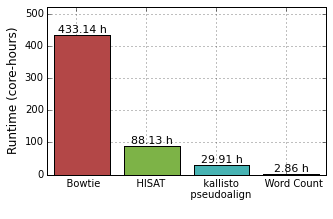

In [5]:
%matplotlib inline

menMeans = [float(i)/60 for i in (bowtie1,hisat,TCC,wc)]

file_list=['hisat_genome_time1.txt','kallipso_time.txt']
times=np.zeros((len(file_list),1))
cur_time=0
for ind in range(len(file_list)):
    with open ('../Zeisel_pipeline/'+file_list[ind]) as f:
        for line in f:
            line1=line.split()
            if len(line1)==2 and (line1[0]=='user' or line1[0]=='sys'):
                line2 = re.split("[ms]+", line1[1])
                cur_time += int(line2[0])*60 + float(line2[1])
    times[ind]=(float(cur_time)/3600)
    cur_time=0
    
menMeans = [300.5*float(menMeans[0])/60] + [i[0] for i in times.tolist()] + [300.5*float(menMeans[-1])/60]

# Plot
N=4
HSV_tuples = [(x*1.0/N, 0.6, 0.7) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
ind = np.arange(N)
width = 0.45
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rects = ax.bar(ind, menMeans, width=0.8, color=RGB_tuples, 
               zorder=4, align='center',label='Read mapping')
methods = ['    Bowtie \n', '   HISAT \n','   kallisto\n   pseudoalign \n',
           '     Word Count',]

rects = ax.patches
ii = 0
hts=map(lambda x: ("%.2f" % x) +' h',menMeans)
for rect, ht in zip(rects, hts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, 
            ht, ha='center', va='bottom',fontsize=11)
    ii += 1

plt.grid()
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] -0.2 for patch in rects]
plt.xticks(xticks_pos, methods, ha='center', rotation=0, size=10)
plt.ylim(0,np.max(menMeans)*1.2)
plt.ylabel('Runtime (core-hours)',size=12)  

plt.show()

We also took a look at what happens if we ran HISAT on the human transcriptome, which is much smaller than the human genome. We expect a great improvement in runtime. HISAT's --no-splice-alignment option was used.

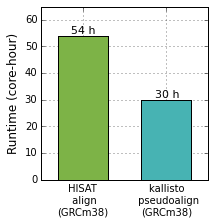

In [6]:
file_list=['../Zeisel_pipeline/hisat_full_time.txt',
           '../Zeisel_pipeline/kallipso_time.txt']
n = len(file_list)
times=np.zeros((n,1))

cur_time=0
for ind in range(n):
    with open (file_list[ind]) as f:
        for line in f:
            line1=line.split()
            if len(line1)==2 and (line1[0]=='user' or line1[0]=='sys'):
                line2 = re.split("[ms]+", line1[1])
                cur_time += int(line2[0])*60 + float(line2[1])
    times[ind]=float(cur_time)
    cur_time=0

menMeans = np.round(times/3600)

ind = np.arange(n)

fig = plt.figure(figsize=(3,4))
plt.gcf().subplots_adjust(bottom=0.3)
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, menMeans, width=0.6, 
                color=(RGB_tuples[1],RGB_tuples[2]),zorder=4, align='center')
methods = ['HISAT \n align \n(GRCm38)','kallisto \n pseudoalign \n(GRCm38)']
plt.grid()

plt.xticks(range(n),methods, ha='center', rotation=0, size=10)

rects = ax.patches
hts=map(lambda x: str(int(x))+' h',menMeans)
for rect, ht in zip(rects, hts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, 
            ht, ha='center', va='bottom',fontsize=11)
plt.xlim(-0.5,n-0.5)
plt.ylim(0,1.2*np.max(menMeans) )
plt.ylabel('Runtime (core-hour)',size=12)
plt.show()

For each dataset, we expect that off-the-shelf clustering algorithms run in approximately the same time after the $n \times n$ distance matrix is obtained, where $n$ is the number of cells (3005 for Zeisel's dataset). The bottle-neck to post-read-mapping processing is in the obtaining of the distance matrices. 

For Bowtie and HISAT, we obtain gene or transcript expression vectors, and therefore we find distances between length-20000 vectors. For TCC-based approaches, we find distances between length-400000 vectors. 

We examine how of much of a difference this makes below.

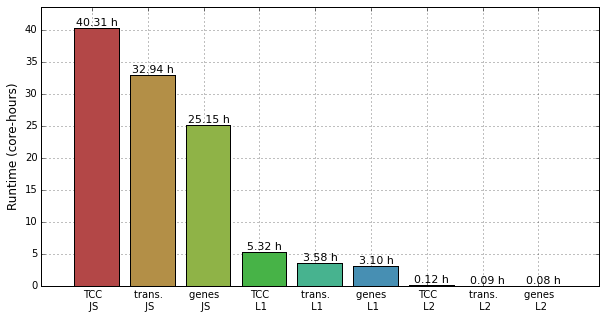

In [14]:
# Time clusterings

# Run times for alignment and pseudoalignment
menMeans = [float(i)/3600 for i in (bowtie1,hisat,TCC)]

# Run times for clustering
os.system('bash time_pairwise_distances.sh')
file_list=['time_TCC.txt','time_kallisto.txt','time_UMI.txt',
           'Zeisel_new_l1_TCC.time','Zeisel_new_l1_Kallisto.time','Zeisel_new_l1_UMI.time',
           'Zeisel_new_l2_TCC.time','Zeisel_new_l2_Kallisto.time','Zeisel_new_l2_UMI.time']
times=np.zeros((len(file_list),1))
cur_time=0
for ind in range(len(file_list)):
    with open ('../Zeisel_pipeline/'+file_list[ind]) as f:
        for line in f:
            line1=line.split()
            if len(line1)==2 and (line1[0]=='user' or line1[0]=='sys'):
                line2 = re.split("[ms]+", line1[1])
                cur_time += int(line2[0])*60 + float(line2[1])
    times[ind]=(float(cur_time)/3600)
    cur_time=0

# Plot
N=len(file_list)
HSV_tuples = [(x*1.0/N, 0.6, 0.7) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
ind = np.arange(N)
width = 0.45
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
rects = ax.bar(ind, times, width=0.8, color=RGB_tuples, 
               zorder=4, align='center',label='Read mapping')
methods = ['TCC \n JS','trans. \n JS','genes \n JS',
           'TCC \n L1','trans. \n L1','genes \n L1',
           'TCC \n L2','trans. \n L2','genes \n L2',]

rects = ax.patches
ii = 0
hts=map(lambda x: ("%.2f" % x) +' h',times)
for rect, ht in zip(rects, hts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, 
            ht, ha='center', va='bottom',fontsize=11)
    ii += 1

plt.grid()
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] -0.2 for patch in rects]
plt.xticks(xticks_pos, methods, ha='center', rotation=0, size=10)
plt.ylabel('Runtime (core-hours)',size=12)    
plt.ylim(0,1.08*np.max(times))  
plt.show()

Both the length and the sparsity of the vectors affect the computation time. We can look at how long and sparse each vector depending on whether TCC, transcript abundances, or gene abundances are used.

In [41]:
method_names = ['UMI genes','kallisto transcripts','TCC']
flnames = ['/data/SS_RNA_seq/Code/pickled/cleaned_UMI_genes_matrix_normalised_subsample100.dat',
           '/data/SS_RNA_seq/Code/pickled/sparse_kallisto_CPM_no_bias_unnormalised_subsample100.dat',
           '../Zeisel_pipeline/Zeisel_TCC_distribution_subsample100_full.dat']
ii = 0
for f in flnames:
    i = pickle.load(file(f,'rb'))
    print method_names[ii] + ' vectors contain:'
    print ' '+ str(np.shape(i)[1]) + ' entries,'
    zz = np.zeros(3005)
    for j in range(3005):
        if scipy.sparse.issparse(i):
            zz[j] = (i.getrow(j) > 0).sum()
        else:
            zz[j] = np.sum(i[j,:] > 0)
        zz[j] = float(zz[j])
    print ' '+str(np.sum(zz)/3005)+' non-zero entries on average,'
    s = 0
    i = scipy.sparse.csc_matrix(i)
    for j in range(np.shape(i)[1]):
        if i.getcol(j).sum() == 0: s += 1
    print ' '+str(s)+' columns that sum to 0'
    ii += 1

UMI genes vectors contain:
 30735 entries,
 6747.40399334 non-zero entries on average,
 2485 columns that sum to 0
kallisto transcripts vectors contain:
 88198 entries,
 8654.67121464 non-zero entries on average,
 5457 columns that sum to 0
TCC vectors contain:
 344224 entries,
 11804.1963394 non-zero entries on average,
 97243 columns that sum to 0


## Trapnell's dataset <a id='section2'></a>

To confirm kallisto's pseudoalignment speed over hisat's alignment speed, we re-ran kallisto and HISAT on Trapnell's dataset. Unlike Zeisel's dataset, reads from Trapnell's dataset come from various locations within the transcript rather than just the beginning of the transcript (where the UMI would be). 

We ran HISAT using both the entire human genome (hg19) and using just the human transcriptome (GRCh38). For the latter, we used the "--no-splice-alignment" option.

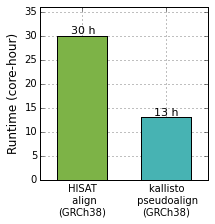

In [108]:
file_list=['../Trapnell_pipeline/hisat_transcriptome_pseudo_time.txt',
           '../Trapnell_pipeline/kallisto_time.txt']
n = len(file_list)
times=np.zeros((n,1))

cur_time=0
for ind in range(n):
    with open (file_list[ind]) as f:
        for line in f:
            line1=line.split()
            if len(line1)==2 and (line1[0]=='user' or line1[0]=='sys'):
                line2 = re.split("[ms]+", line1[1])
                cur_time += int(line2[0])*60 + float(line2[1])
    times[ind]=float(cur_time)
    cur_time=0

menMeans = np.round(times/3600)

ind = np.arange(n)

fig = plt.figure(figsize=(3,4))
plt.gcf().subplots_adjust(bottom=0.3)
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, menMeans, width=0.6, 
                color=(RGB_tuples[1],RGB_tuples[2]),zorder=4, align='center')
methods = ['HISAT \n align \n(GRCh38)','kallisto \n pseudoalign \n(GRCh38)']
plt.grid()

plt.xticks(range(n),methods, ha='center', rotation=0, size=10)

rects = ax.patches
hts=map(lambda x: str(int(x))+' h',menMeans)
for rect, ht in zip(rects, hts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, 
            ht, ha='center', va='bottom',fontsize=11)
plt.xlim(-0.5,n-0.5)
plt.ylim(0,1.2*np.max(menMeans) )
plt.ylabel('Runtime (core-hour)',size=12)
plt.show()